In [1]:
from crewai import Agent, Task, Crew
from langchain_google_genai import ChatGoogleGenerativeAI
from crewai_tools import SerperDevTool
import os
import litellm


c:\Users\karti\Desktop\Project\Data_analyst_agent\myenv\Lib\site-packages\pydantic\_internal\_generate_schema.py:775: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `CrewAgentExecutor` to V2.
  warn(
c:\Users\karti\Desktop\Project\Data_analyst_agent\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

In [3]:
# an agent tool from the langchain which is able to gave the environment for python code
python_repl = PythonREPL() 

In [4]:
import json

In [5]:
# 2. Configure LiteLLM for Gemini DIRECTLY
litellm.drop_params = True
litellm.set_verbose = True


In [6]:
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
import os 

In [8]:
API_KEY = os.getenv("Gemini_API_KEY")

In [9]:
os.environ["GEMINI_API_KEY"] = API_KEY
os.environ["LITELLM_PROVIDER"] = "google"  # Force LiteLLM to use Google

In [10]:
# 2. Configure Gemini PROPERLY
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.7,
    #max_output_tokens=2048,
    google_api_key= os.getenv("Gemini_API_KEY")  # Explicit key assignment
)


In [11]:
import os
import pandas as pd
from pydantic import BaseModel, Field
from crewai import Agent, Task, Crew, Process
from langchain.tools import BaseTool

In [12]:
# ------------------------
# Universal Data Tools
# ------------------------

class FileInputSchema(BaseModel):
    filename: str = Field(..., description="Path to CSV file")

class DataLoaderTool(BaseTool):
    name = "data_loader"
    description = "Load and validate any CSV file with dynamic typing"
    
    def _run(self, filename: str) -> pd.DataFrame | str:
        """Load and validate any CSV file with dynamic typing"""
        try:
            # Input validation
            if not os.path.exists(filename):
                return f"File not found: {filename}"
            if not filename.endswith('.csv'):
                return "Only CSV files are supported"

            # Load data with automatic type detection
            df = pd.read_csv(filename)
            
            # Basic validation
            if df.empty:
                return "Empty CSV file"
                
            return df

        except Exception as e:
            return f"Data loading failed: {str(e)}"

class StatisticalAnalyzerTool(BaseTool):
    name = "statistical_analyzer"
    description = "Analyze any CSV file's numerical features including correlation analysis"
    
    def _run(self, filename: str) -> str:
        """Analyze any CSV file's numerical features including correlation analysis"""
        try:
            # Create an instance of the data loader tool
            data_loader_tool = DataLoaderTool()
            
            # Load data
            data = data_loader_tool._run(filename)
            if isinstance(data, str):
                return data  # Return error message
                
            report = [
                f"# Statistical Report for {os.path.basename(filename)}",
                f"**Dataset Shape:** {data.shape[0]} rows, {data.shape[1]} columns"
            ]
            
            # Numerical Analysis
            numeric_cols = data.select_dtypes(include=['number']).columns
            if len(numeric_cols) > 0:
                report.append("\n## Numerical Features Analysis")
                for col in numeric_cols:
                    stats = data[col].describe(percentiles=[.25, .75])
                    report.extend([
                        f"\n### {col}",
                        f"- Mean: {stats['mean']:.2f}",
                        f"- Median: {stats['50%']:.2f}",
                        f"- Std Dev: {stats['std']:.2f}",
                        f"- Range: {stats['min']:.2f} to {stats['max']:.2f}",
                        f"- IQR: {stats['75%'] - stats['25%']:.2f}"
                    ])
            
            # Categorical Analysis
            cat_cols = data.select_dtypes(include=['object', 'category']).columns
            if len(cat_cols) > 0:
                report.append("\n## Categorical Features Analysis")
                for col in cat_cols:
                    counts = data[col].value_counts()
                    report.extend([
                        f"\n### {col}",
                        f"- Unique Values: {len(counts)}",
                        f"- Most Common: {counts.idxmax()} ({counts.max()} entries)"
                    ])
            
            # Correlation Analysis
            if len(numeric_cols) > 1:
                report.append("\n## Correlation Analysis")
                # Calculate correlation matrix
                corr_matrix = data[numeric_cols].corr()
                
                # Format correlation matrix as markdown
                report.append("\n### Correlation Matrix")
                report.append(corr_matrix.round(2).to_markdown())
                
                # Find strong correlations (absolute value > 0.5)
                strong_corrs = []
                for i in range(len(numeric_cols)):
                    for j in range(i+1, len(numeric_cols)):
                        col1 = numeric_cols[i]
                        col2 = numeric_cols[j]
                        corr_value = corr_matrix.iloc[i, j]
                        if abs(corr_value) > 0.5:
                            strength = "Strong Positive" if corr_value > 0.7 else "Moderate Positive" if corr_value > 0 else "Strong Negative" if corr_value < -0.7 else "Moderate Negative"
                            strong_corrs.append({
                                'Feature 1': col1,
                                'Feature 2': col2, 
                                'Correlation': f"{corr_value:.2f}",
                                'Strength': strength
                            })
                
                if strong_corrs:
                    report.append("\n### Strong Feature Correlations")
                    report.append("*Correlations with absolute value > 0.5*")
                    report.append(pd.DataFrame(strong_corrs).to_markdown(index=False))
                else:
                    report.append("\n*No strong correlations found between features (threshold: 0.5)*")
            
            return "\n".join(report)
            
        except Exception as e:
            return f"Analysis failed: {str(e)}"
        
        
class AnomalyDetectorTool(BaseTool):
    name = "anomaly_detector"
    description = "Detect anomalies in any CSV dataset"
    
    def _run(self, filename: str) -> str:
        """Detect anomalies in any CSV dataset"""
        try:
            # Create an instance of the data loader tool
            data_loader_tool = DataLoaderTool()
            
            # Load data
            data = data_loader_tool._run(filename)
            if isinstance(data, str):
                return data
                
            report = [
                f"# Anomaly Report for {os.path.basename(filename)}",
                f"**Total Records:** {len(data):,}"
            ]
            
            # Data Quality Checks
            quality = pd.DataFrame({
                'Missing Values': data.isna().sum(),
                'Zero Values': (data == 0).sum(),
                'Unique Values': data.nunique()
            })
            report.append("\n## Data Quality Assessment")
            report.append(quality.to_markdown())
            
            # Numerical Anomalies
            numeric_cols = data.select_dtypes(include=['number']).columns
            if len(numeric_cols) > 0:
                report.append("\n## Numerical Anomalies")
                anomalies = []
                for col in numeric_cols:
                    q1 = data[col].quantile(0.25)
                    q3 = data[col].quantile(0.75)
                    iqr = q3 - q1
                    outliers = data[(data[col] < (q1 - 1.5*iqr)) | (data[col] > (q3 + 1.5*iqr))]
                    anomalies.append({
                        'Feature': col,
                        'Outliers': len(outliers),
                        'Min': data[col].min(),
                        'Max': data[col].max()
                    })
                report.append(pd.DataFrame(anomalies).to_markdown(index=False))
            
            return "\n".join(report)
            
        except Exception as e:
            return f"Anomaly detection failed: {str(e)}"
        


class VisualizationTool(BaseTool):
    name = "data_visualizer"
    description = "Create various visualizations from CSV data"
    
    def _run(self, 
             file_path: str,  # Full path to the CSV file
             chart_type: str,  # Type of chart to create
             x_axis: str = None,  # X-axis column
             y_axis: str = None,  # Y-axis column
             column_name: str = None,  # Alternative to x_axis for single-column charts
             title: str = None,  # Chart title
             output_path: str = None) -> str:  # Where to save the chart
        """
        Create visualizations from CSV data
        """
        try:
            # Import required libraries
            import matplotlib
            matplotlib.use('Agg')  # Use non-interactive backend
            import matplotlib.pyplot as plt
            import seaborn as sns
            import pandas as pd
            import os
            import numpy as np
            
            # First, validate the chart_type
            valid_chart_types = ["scatter", "histogram", "boxplot", "heatmap", "bar", "line"]
            
            # Normalize the chart type
            normalized_chart_type = chart_type.lower().replace("_", "").replace("-", "").replace(" ", "")
            if normalized_chart_type in ["scatter", "scatterplot"]:
                chart_type = "scatter"
            elif normalized_chart_type in ["bar", "barchart"]:
                chart_type = "bar"
            elif normalized_chart_type in ["line", "linechart"]:
                chart_type = "line"
            elif normalized_chart_type in ["box", "boxplot"]:
                chart_type = "boxplot"
            elif normalized_chart_type in ["heat", "heatmap"]:
                chart_type = "heatmap"
            elif normalized_chart_type in ["hist", "histogram"]:
                chart_type = "histogram"
            else:
                return f"Unsupported chart type: {chart_type}. Supported types: scatter/scatter_plot, histogram, bar/bar_chart, line/line_chart, boxplot/box_plot, heatmap/heat_map"
            
            # Validate the file exists
            if not os.path.exists(file_path):
                return f"File not found: {file_path}"
            
            # Load data
            try:
                data = pd.read_csv(file_path)
                if data.empty:
                    return "Empty CSV file"
            except Exception as e:
                return f"Failed to load CSV file: {str(e)}"
            
            # Set default output path if not provided
            if not output_path:
                output_dir = os.path.dirname(file_path)
                # Ensure output directory exists
                if not output_dir:
                    output_dir = "."
                base_name = os.path.splitext(os.path.basename(file_path))[0]
                output_path = os.path.join(output_dir, f"{base_name}_{chart_type}_plot.png")
            
            # Column validation and handling
            available_columns = list(data.columns)
            
            # Handle the case when column_name is provided but not in the dataset
            if column_name and column_name not in available_columns:
                return f"Column '{column_name}' not found in dataset. Available columns: {', '.join(available_columns)}"
            
            # Handle the case when x_axis is provided but not in the dataset
            if x_axis and x_axis not in available_columns:
                return f"Column '{x_axis}' not found in dataset. Available columns: {', '.join(available_columns)}"
                
            # Handle the case when y_axis is provided but not in the dataset
            if y_axis and y_axis not in available_columns:
                return f"Column '{y_axis}' not found in dataset. Available columns: {', '.join(available_columns)}"
            
            # Figure setup
            plt.figure(figsize=(12, 8))
            
            # Create the visualization based on the chart type
            if chart_type == "histogram":
                # Use column_name if provided, otherwise use x_axis
                col = column_name if column_name else x_axis
                if not col:
                    return "Histogram requires either column_name or x_axis parameter"
                
                # Ensure the column has numerical data
                if not pd.api.types.is_numeric_dtype(data[col]):
                    return f"Column '{col}' must contain numerical data for histogram"
                    
                sns.histplot(data=data, x=col, kde=True)
                plt.title(title or f"Distribution of {col}")
                plt.xlabel(col)
                plt.ylabel("Frequency")
                
            elif chart_type == "scatter":
                if not x_axis or not y_axis:
                    return "Scatter plot requires both x_axis and y_axis parameters"
                
                # Ensure both columns have numerical data
                if not pd.api.types.is_numeric_dtype(data[x_axis]):
                    return f"Column '{x_axis}' must contain numerical data for scatter plot"
                if not pd.api.types.is_numeric_dtype(data[y_axis]):
                    return f"Column '{y_axis}' must contain numerical data for scatter plot"
                    
                sns.scatterplot(data=data, x=x_axis, y=y_axis)
                plt.title(title or f"{y_axis} vs {x_axis}")
                plt.xlabel(x_axis)
                plt.ylabel(y_axis)
                
            elif chart_type == "boxplot":
                col = column_name if column_name else y_axis if y_axis else x_axis
                if not col:
                    return "Box plot requires either column_name, x_axis, or y_axis parameter"
                
                # Ensure the column has numerical data
                if not pd.api.types.is_numeric_dtype(data[col]):
                    return f"Column '{col}' must contain numerical data for box plot"
                    
                sns.boxplot(data=data, y=col)
                plt.title(title or f"Distribution of {col}")
                plt.ylabel(col)
                
            elif chart_type == "heatmap":
                # For heatmap, use all numeric columns
                numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
                
                if len(numeric_cols) < 2:
                    return "Heatmap requires at least 2 numeric columns in the dataset"
                
                # If x_axis and y_axis are specified and both are numeric, use them
                if x_axis and y_axis:
                    if x_axis in numeric_cols and y_axis in numeric_cols:
                        cols = [x_axis, y_axis]
                    else:
                        return "Both x_axis and y_axis must be numeric columns for heatmap"
                else:
                    cols = numeric_cols
                
                # Handle NaN values in the correlation matrix
                corr_matrix = data[cols].corr().fillna(0)
                
                sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
                plt.title(title or "Correlation Heatmap")
                
            elif chart_type == "bar":
                if not x_axis:
                    return "Bar chart requires an x_axis parameter"
                    
                if not y_axis:
                    # Simple count bar chart
                    counts = data[x_axis].value_counts().sort_values(ascending=False)
                    
                    # Handle too many categories
                    if len(counts) > 20:
                        counts = counts.head(20)
                        plt.title(title or f"Top 20 {x_axis} Categories")
                    else:
                        plt.title(title or f"Frequency of {x_axis}")
                    
                    sns.barplot(x=counts.index, y=counts.values)
                    plt.xlabel(x_axis)
                    plt.ylabel("Count")
                else:
                    # Check if y_axis is numeric
                    if not pd.api.types.is_numeric_dtype(data[y_axis]):
                        return f"Column '{y_axis}' must contain numerical data for bar chart"
                        
                    # Aggregated bar chart
                    agg_data = data.groupby(x_axis)[y_axis].mean().sort_values(ascending=False)
                    
                    # Handle too many categories
                    if len(agg_data) > 20:
                        agg_data = agg_data.head(20)
                        plt.title(title or f"Top 20 Average {y_axis} by {x_axis}")
                    else:
                        plt.title(title or f"Average {y_axis} by {x_axis}")
                    
                    sns.barplot(x=agg_data.index, y=agg_data.values)
                    plt.xlabel(x_axis)
                    plt.ylabel(f"Average {y_axis}")
                
                # Rotate x labels if there are many categories
                if len(data[x_axis].unique()) > 5:
                    plt.xticks(rotation=45, ha='right')
                
            elif chart_type == "line":
                if not x_axis or not y_axis:
                    return "Line chart requires both x_axis and y_axis parameters"
                
                # Sort data by x_axis for better line plots
                if pd.api.types.is_numeric_dtype(data[x_axis]):
                    sorted_data = data.sort_values(by=x_axis)
                    plt.plot(sorted_data[x_axis], sorted_data[y_axis])
                else:
                    # For categorical x_axis, we can use a line plot with markers
                    agg_data = data.groupby(x_axis)[y_axis].mean().reset_index()
                    plt.plot(agg_data[x_axis], agg_data[y_axis], marker='o')
                    plt.xticks(rotation=45, ha='right')
                
                plt.title(title or f"{y_axis} vs {x_axis}")
                plt.xlabel(x_axis)
                plt.ylabel(y_axis)
                
            # Finalize and save the visualization
            plt.tight_layout()
            try:
                plt.savefig(output_path)
                plt.close()
                return f"Visualization created successfully: {output_path}"
            except Exception as e:
                return f"Failed to save visualization: {str(e)}"
            
        except Exception as e:
            import traceback
            return f"Visualization failed: {str(e)}\nTraceback: {traceback.format_exc()}"

# ------------------------
# Agent and Crew Setup
# ------------------------

# Create tools
data_loader_tool = DataLoaderTool()
statistical_analyzer_tool = StatisticalAnalyzerTool()
anomaly_detector_tool = AnomalyDetectorTool()
visualization_tool = VisualizationTool()

In [13]:
# too consider for the python environment 
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

In [14]:
data_analyst = Agent(
    role="Data Analyst",
    goal="Analyze CSV data files and provide meaningful insights",
    backstory="""You are an expert data analyst with years of experience working with CSV data.
    Your specialties include data cleaning, exploratory data analysis, and finding patterns in complex datasets.
    You're known for your ability to explain complex data insights in simple terms.""",
    verbose=True,
    allow_delegation=False,
    tools=[
        data_loader_tool,  # Use tool instances, not classes
        statistical_analyzer_tool, 
        anomaly_detector_tool,
    ],
    llm=llm
)

In [15]:
coding_data_analyst_agent = Agent(
    role = "Data Visualizer",
    goal = "Generate insightful visualizations such as bar charts, pie charts, and other plots based on data requirements.",
    backstory = "You are an expert in data visualization with extensive experience in creating meaningful charts and graphs to uncover key insights from datasets.",
    allow_code_execution = True,
    tools = [visualization_tool, repl_tool],    
    llm = llm
)


In [16]:
# Ask the user for the CSV file path
csv_path = input("Enter the CSV file path: ")

In [17]:
csv_path

'C:\\Users\\karti\\Desktop\\Project\\Data_analyst_agent\\Indian Rainfall Dataset District-wise Daily Measurements.csv'

In [18]:
name = input("enter the name of the file you want to save the data to:")

In [19]:
name 

'rainfall2'

In [20]:
#-------------------------#
#  Data Validation Task   #
#-------------------------#
data_validation_task = Task(
    description=f"Validate and load data from '{csv_path}'",
    expected_output="JSON report with data quality metrics",  # Required field
    agent=data_analyst,  # Required field
    tools=[data_loader_tool],
    config={
        'timeout': 300,
        'max_file_size': "500MB"
    }
)

#-------------------------#
#  Statistical Analysis   #
#-------------------------#
statistical_analysis_task = Task(
    description=(
        "Perform a comprehensive statistical analysis of the dataset to uncover key insights, trends, and relationships. "
        "Identify patterns, correlations, and any anomalies that may impact decision-making. "
        "Provide actionable observations along with recommendations for further analysis."
    ),
    expected_output=(
        "A detailed statistical summary highlighting key findings, including trends, correlations, and potential outliers. "
        "Clearly outline observations and suggest additional analyses that could add value for the client."
    ),  
    agent=data_analyst,  
    tools=[statistical_analyzer_tool],  # Uncomment if using specific analysis tools
    context=[data_validation_task],  
    output_file=f"{name}_statistical_analysis_report.md"
)
#-------------------------#
#  Anomaly Detection      #
#-------------------------#
anomaly_detection_task = Task(
    description=(
        "Detect anomalies and quality issues in the dataset using statistical and analytical techniques. "
        "Analyze patterns to identify outliers, inconsistencies, or missing values that may affect data integrity. "
        "Propose effective strategies to resolve these anomalies and enhance overall data quality."
    ),
    expected_output=(
        "A detailed anomaly detection report outlining identified anomalies, their potential impact, and recommended resolution strategies. "
        "Provide a step-by-step approach to handling these anomalies using statistical techniques, ensuring improved data reliability."
    ),  
    agent=data_analyst,  
    tools=[anomaly_detector_tool,statistical_analyzer_tool],  # Uncomment if using specific anomaly detection tools
    context=[data_validation_task],  
    output_file=f"{name}_anomaly_detection_report.md"
)

#-------------------------#
#  Visualization Task      #
#-------------------------#
visualization_task = Task(
    description="Generate multiple insightful visualizations from the data to uncover key patterns and trends.",
    expected_output=(
        "Create multiple visualization plots and provide a detailed explanation for each. "
        "Plot the graph properly and save it in the output_file "
        "For each plot, describe what it represents, the insights it reveals, and how it contributes "
        "to understanding the dataset."
    ),  
    agent = coding_data_analyst_agent,  
    tools=[visualization_tool,repl_tool],
    #tools = repl_tool,
    context=[data_validation_task],
    config={'plot_type': 'auto', 'figsize': (12, 8)},
    output_file =f"{name}_visualization_report.md"
)

In [21]:
# Create the analysis crew with validated components
data_analysis_crew = Crew(
    agents=[data_analyst,coding_data_analyst_agent],
    tasks=[
        data_validation_task,
        statistical_analysis_task,
        anomaly_detection_task,
        visualization_task,
    ],
    verbose=2
)

 [DEBUG]: == Working Agent: Data Analyst
 [INFO]: == Starting Task: Validate and load data from 'C:\Users\karti\Desktop\Project\Data_analyst_agent\Indian Rainfall Dataset District-wise Daily Measurements.csv'


> Entering new CrewAgentExecutor chain...
Okay, I need to load the CSV file 'C:\Users\karti\Desktop\Project\Data_analyst_agent\Indian Rainfall Dataset District-wise Daily Measurements.csv' to validate the data and then generate a JSON report with data quality metrics.

Action: data_loader
Action Input: {"file_path": "C:\\Users\\karti\\Desktop\\Project\\Data_analyst_agent\\Indian Rainfall Dataset District-wise Daily Measurements.csv"} 

     state;"district";"month";"1st";"2nd";"3rd";"4th";"5th";"6th";"7th";"8th";"9th";"10th";"11th";"12th";"13th";"14th";"15th";"16th";"17th";"18th";"19th";"20th";"21st";"22nd";"23rd";"24th";"25th";"26th";"27th";"28th";"29th";"30th";"31st"
0     Andaman & Nicobar;"Nicobars";1;0.0;0.0;0.0;0.0...                                                        

2025-03-19 16:42:45,636 - 15888 - python.py-python:17 - WARNING: Python REPL can execute arbitrary code. Use with caution.


 

Trying comma separator:
  state;"district";"month";"1st";"2nd";"3rd";"4th";"5th";"6th";"7th";"8th";"9th";"10th";"11th";"12th";"13th";"14th";"15th";"16th";"17th";"18th";"19th";"20th";"21st";"22nd";"23rd";"24th";"25th";"26th";"27th";"28th";"29th";"30th";"31st"
0  Andaman & Nicobar;"Nicobars";1;0.0;0.0;0.0;0.0...                                                                                                                                                                                      
1  Andaman & Nicobar;"North And Middle Andaman";1...                                                                                                                                                                                      
2  Andaman & Nicobar;"South Andamans";1;0.0;0.0;0...                                                                                                                                                                                      
3  Andhra Pradesh;"Anantapur";1;0

2025-03-19 16:42:46,216 - 15888 - before_sleep.py-before_sleep:65 - WARNING: Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
2025-03-19 16:42:48,616 - 15888 - before_sleep.py-before_sleep:65 - WARNING: Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


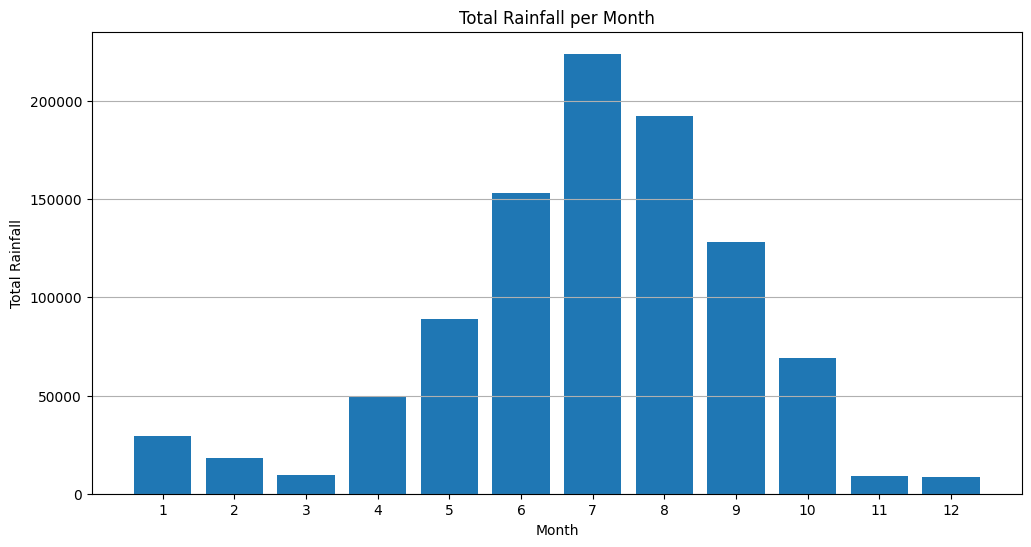

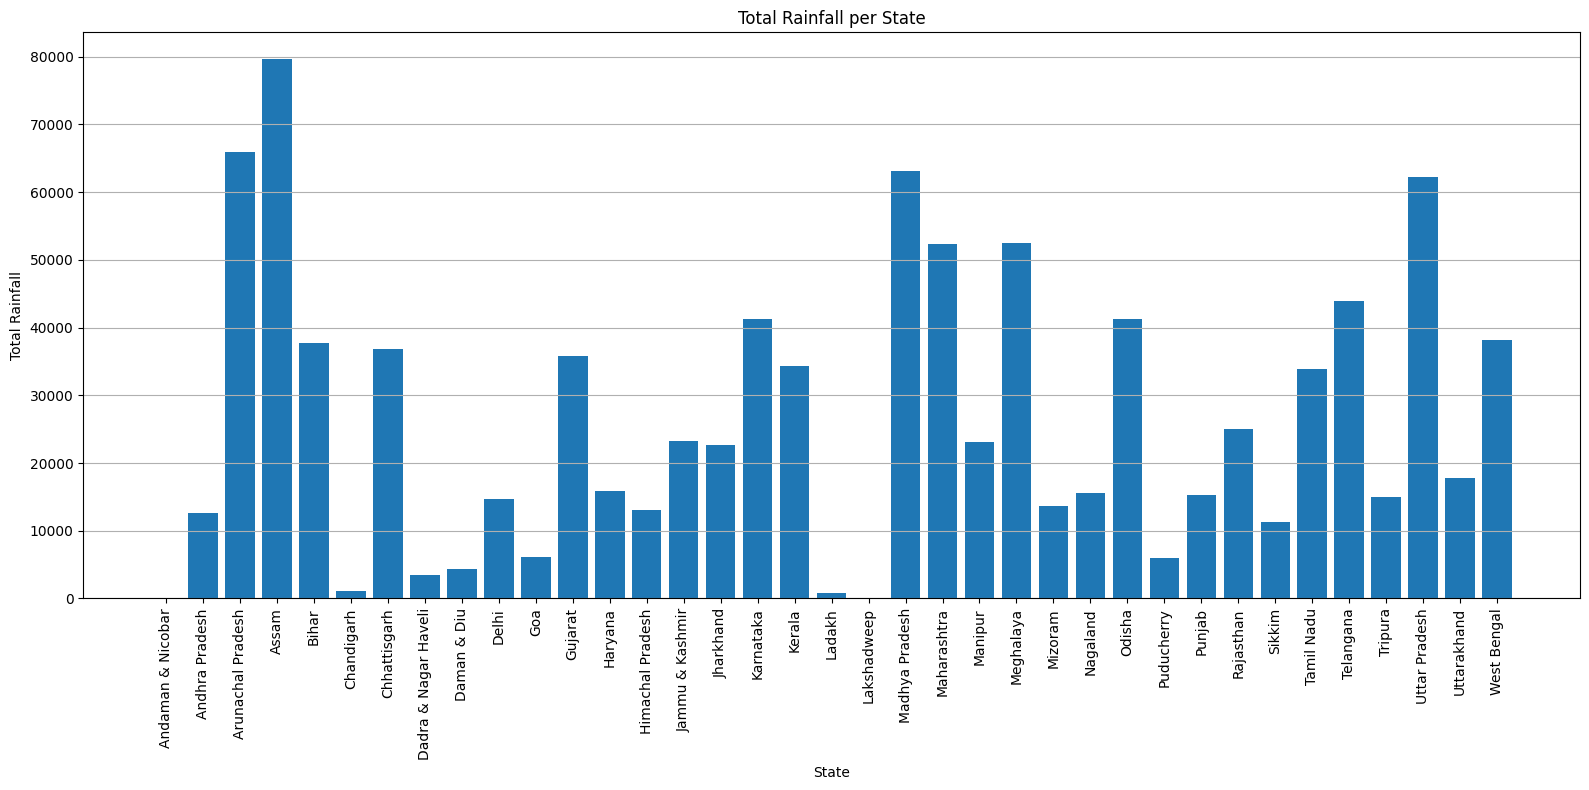

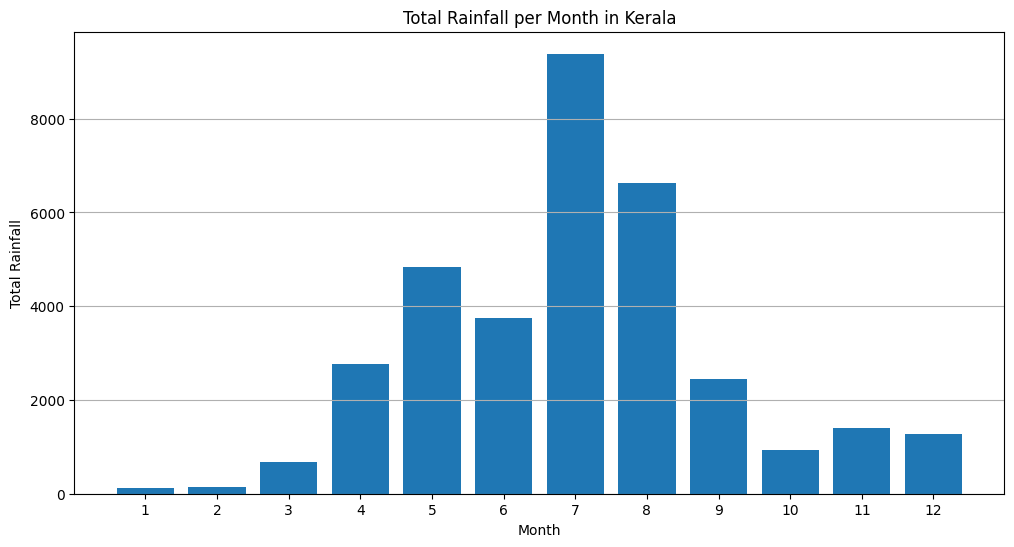

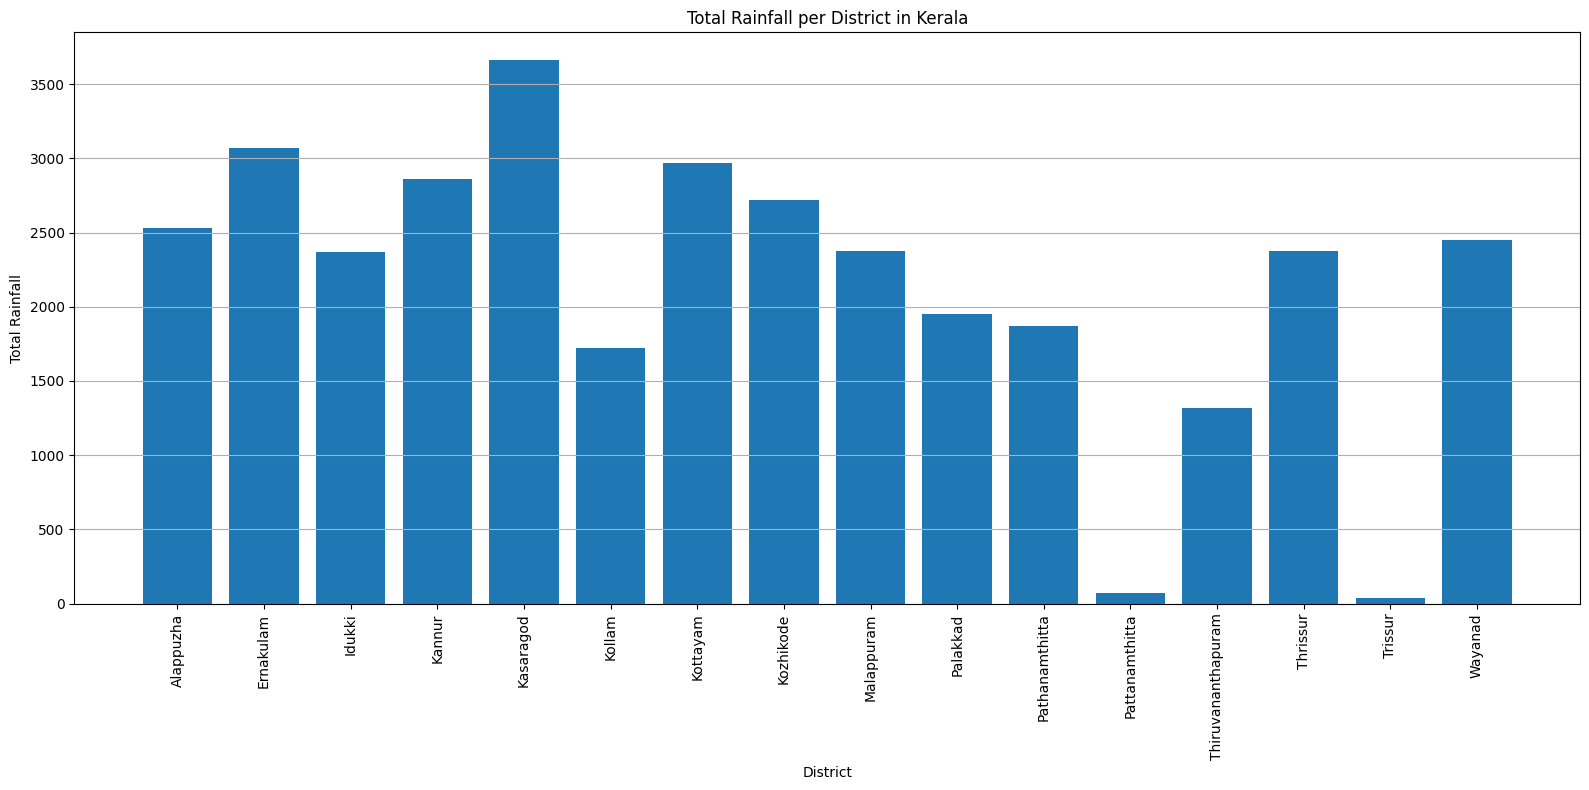

 



 [DEBUG]: == [Data Visualizer] Task output: ```python
import pandas as pd
import matplotlib.pyplot as plt

# Load the data with the correct separator (semicolon)
file_path = 'C:\\Users\\karti\\Desktop\\Project\\Data_analyst_agent\\Indian Rainfall Dataset District-wise Daily Measurements.csv'
df = pd.read_csv(file_path, sep=';')

# 1. Bar chart: Total Rainfall per Month
monthly_rainfall = df.groupby('month')[['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st']].sum().sum(axis=1)

plt.figure(figsize=(12, 6))
plt.bar(monthly_rainfall.index, monthly_rainfall.values)
plt.xlabel('Month')
plt.ylabel('Total Rainfall')
plt.title('Total Rainfall per Month')
plt.xticks(monthly_rainfall.index)
plt.grid(axis='y')
plt.savefig('monthly_rainfall_bar_chart.png')
plt.show()

# Explanation:
# This bar chart shows th

In [22]:
# Run the crew normally
result = data_analysis_crew.kickoff()

In [23]:
print(data_analysis_crew.agents)  # Should not be an empty list

[Agent(role=Data Analyst, goal=Analyze CSV data files and provide meaningful insights, backstory=You are an expert data analyst with years of experience working with CSV data.
    Your specialties include data cleaning, exploratory data analysis, and finding patterns in complex datasets.
    You're known for your ability to explain complex data insights in simple terms.), Agent(role=Data Visualizer, goal=Generate insightful visualizations such as bar charts, pie charts, and other plots based on data requirements., backstory=You are an expert in data visualization with extensive experience in creating meaningful charts and graphs to uncover key insights from datasets.)]


In [24]:
from IPython.display import display 
display(result)


"```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the data with the correct separator (semicolon)\nfile_path = 'C:\\\\Users\\\\karti\\\\Desktop\\\\Project\\\\Data_analyst_agent\\\\Indian Rainfall Dataset District-wise Daily Measurements.csv'\ndf = pd.read_csv(file_path, sep=';')\n\n# 1. Bar chart: Total Rainfall per Month\nmonthly_rainfall = df.groupby('month')[['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st']].sum().sum(axis=1)\n\nplt.figure(figsize=(12, 6))\nplt.bar(monthly_rainfall.index, monthly_rainfall.values)\nplt.xlabel('Month')\nplt.ylabel('Total Rainfall')\nplt.title('Total Rainfall per Month')\nplt.xticks(monthly_rainfall.index)\nplt.grid(axis='y')\nplt.savefig('monthly_rainfall_bar_chart.png')\nplt.show()\n\n# Explanation:\n# This bar chart shows the total rainfa

In [25]:
from IPython.display import Markdown

Markdown(result)

```python
import pandas as pd
import matplotlib.pyplot as plt

# Load the data with the correct separator (semicolon)
file_path = 'C:\\Users\\karti\\Desktop\\Project\\Data_analyst_agent\\Indian Rainfall Dataset District-wise Daily Measurements.csv'
df = pd.read_csv(file_path, sep=';')

# 1. Bar chart: Total Rainfall per Month
monthly_rainfall = df.groupby('month')[['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st']].sum().sum(axis=1)

plt.figure(figsize=(12, 6))
plt.bar(monthly_rainfall.index, monthly_rainfall.values)
plt.xlabel('Month')
plt.ylabel('Total Rainfall')
plt.title('Total Rainfall per Month')
plt.xticks(monthly_rainfall.index)
plt.grid(axis='y')
plt.savefig('monthly_rainfall_bar_chart.png')
plt.show()

# Explanation:
# This bar chart shows the total rainfall for each month across all districts and states.
# Insights: It reveals the months with the highest and lowest rainfall, providing an overview of the rainfall distribution throughout the year.
# Contribution: It helps in understanding the overall seasonal rainfall pattern.

# 2. Bar chart: Total Rainfall per State
state_rainfall = df.groupby('state')[['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st']].sum().sum(axis=1)

plt.figure(figsize=(16, 8))
plt.bar(state_rainfall.index, state_rainfall.values)
plt.xlabel('State')
plt.ylabel('Total Rainfall')
plt.title('Total Rainfall per State')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('state_rainfall_bar_chart.png')
plt.show()

# Explanation:
# This bar chart shows the total rainfall for each state.
# Insights: It allows for a comparison of rainfall across different states, highlighting regions with high and low rainfall.
# Contribution: It provides a geographical perspective on rainfall distribution.

# 3. Bar chart: Total Rainfall per Month in Kerala
kerala_data = df[df['state'] == 'Kerala']
kerala_monthly_rainfall = kerala_data.groupby('month')[['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st']].sum().sum(axis=1)

plt.figure(figsize=(12, 6))
plt.bar(kerala_monthly_rainfall.index, kerala_monthly_rainfall.values)
plt.xlabel('Month')
plt.ylabel('Total Rainfall')
plt.title('Total Rainfall per Month in Kerala')
plt.xticks(kerala_monthly_rainfall.index)
plt.grid(axis='y')
plt.savefig('kerala_monthly_rainfall_bar_chart.png')
plt.show()

# Explanation:
# This bar chart shows the total rainfall for each month in Kerala.
# Insights: It reveals the specific months with the highest and lowest rainfall in Kerala, providing a detailed seasonal rainfall pattern for the state.
# Contribution: It allows for a focused analysis of rainfall trends within Kerala.

# 4. Bar chart: Total Rainfall per District in Kerala
kerala_district_rainfall = kerala_data.groupby('district')[['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st']].sum().sum(axis=1)

plt.figure(figsize=(16, 8))
plt.bar(kerala_district_rainfall.index, kerala_district_rainfall.values)
plt.xlabel('District')
plt.ylabel('Total Rainfall')
plt.title('Total Rainfall per District in Kerala')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('kerala_district_rainfall_bar_chart.png')
plt.show()

# Explanation:
# This bar chart shows the total rainfall for each district in Kerala.
# Insights: It allows for a comparison of rainfall across different districts within Kerala, highlighting regional variations.
# Contribution: It provides a granular view of rainfall distribution within the state.
```